# SHRED-ROM Tutorial on Kuramoto Sivashinsky

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eFR-3l6qFgo3360V2LrJqBPSLheI4Mfd)

#### Import Libraries

In [ ]:
# PYSHRED
import pyshred
from pyshred import ParametricDataManager, SHRED, ParametricSHREDEngine

# Other helper libraries
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Kuramoto Sivashinsky dataset

In [35]:
import numpy as np
import urllib.request
# URL of the NPZ file
url = 'https://zenodo.org/records/14524524/files/KuramotoSivashinsky_data.npz?download=1'
# Local filename to save the downloaded file
filename = 'KuramotoSivashinsky_data.npz'
# Download the file from the URL
urllib.request.urlretrieve(url, filename)
# Load the data from the NPZ file
dataset = np.load(filename)

#### Device Info

In [38]:
device = pyshred.set_device("auto")
# device = pyshred.set_device("cpu") # force CPU
# device = pyshred.set_device("cuda") # force CUDA
# device = pyshred.set_device("mps") # force MPS
# device = pyshred.set_device("cuda", device_id=0) # force specific GPU
pyshred.device_info()

=== PyShred Device Information ===
Current device: cpu
Device config: DeviceConfig(device_type=<DeviceType.AUTO: 'auto'>, device_id=None, force_cpu=False, warn_on_fallback=True)

Device Availability:
  CUDA available: False
  MPS available: False
  CPU: Always available


#### Initialize Data Manager

In [42]:
# Initialize ParametricSHREDDataManager
manager = ParametricDataManager(
    lags = 20,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    )

#### Add datasets and sensors

In [43]:
data = dataset['u'] # shape (500, 201, 100)
params = dataset['mu'] # shape (500, 201, 2)


manager.add_data(
    data=data,
    random=3,
    # stationary=[(15,),(30,),(45,)],
    id = 'KS',
    compress = False
)

# add params
manager.add_data(
    data=params,
    # stationary=[(15,),(30,),(45,)],
    id = 'MU',
    compress = False
)


#### Analyze sensor summary

In [44]:
manager.sensor_measurements_df

,KS-0,KS-1,KS-2
0,-0.434038,-1.148071,0.154032
1,-0.457136,-0.961066,0.332515
2,-0.459894,-0.912785,0.361393
3,-0.446475,-0.873385,0.404951
4,-0.389743,-0.829674,0.485893
...,...,...,...
100495,-0.846195,-1.008426,0.261712
100496,-1.671882,-0.458563,-0.622521
100497,-2.103602,0.638096,-1.591052
100498,-1.971333,1.887684,-2.129965


In [45]:
manager.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,KS,0,stationary (random),"(18,)"
1,KS,1,stationary (random),"(93,)"
2,KS,2,stationary (random),"(15,)"


#### Get train, validation, and test set

In [46]:
train_dataset, val_dataset, test_dataset= manager.prepare()

#### Initialize SHRED

When using a `ParametricDataManager`, ensure `latent_forecaster` is set to None.

In [47]:
shred = SHRED(sequence_model="LSTM", decoder_model="MLP", latent_forecaster=None)

#### Fit SHRED

In [48]:
val_errors = shred.fit(train_dataset=train_dataset, val_dataset=val_dataset, num_epochs=20, sindy_regularization=0)
print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.031690
Validation MSE (epoch 1): 0.026569
Epoch 2: Average training loss = 0.016993
Validation MSE (epoch 2): 0.015352
Epoch 3: Average training loss = 0.011736
Validation MSE (epoch 3): 0.012691
Epoch 4: Average training loss = 0.009915
Validation MSE (epoch 4): 0.011286
Epoch 5: Average training loss = 0.008901
Validation MSE (epoch 5): 0.010464
Epoch 6: Average training loss = 0.008259
Validation MSE (epoch 6): 0.009664
Epoch 7: Average training loss = 0.007670
Validation MSE (epoch 7): 0.008933
Epoch 8: Average training loss = 0.007126
Validation MSE (epoch 8): 0.008480
Epoch 9: Average training loss = 0.006610
Validation MSE (epoch 9): 0.008143
Epoch 10: Average training loss = 0.006278
Validation MSE (epoch 10): 0.008485
Epoch 11: Average training loss = 0.005930
Validation MSE (epoch 11): 0.007433
Epoch 12: Average training loss = 0.005582
Validation MSE (epoch 12): 0.006999
Epoch 13: Average training loss = 0.005281
Validation

#### Evaluate SHRED

In [49]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.003
Val   MSE: 0.005
Test  MSE: 0.004


#### Initialize Parametric SHRED Engine for Downstream Tasks

In [50]:
engine = ParametricSHREDEngine(manager, shred)

#### Sensor Measurements to Latent Space

In [51]:
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

#### Decode Latent Space to Full-State Space

In [52]:
test_prediction = engine.decode(test_latent_from_sensors) # latent space generated from sensor data

#### Compare prediction against the truth

Since both number of trajectories (`data.shape[0]`) and number of timesteps (`data.shape[1]`) are both variable, we will leave them combined on the first axis. The remaining axes are all spatial dimensions.

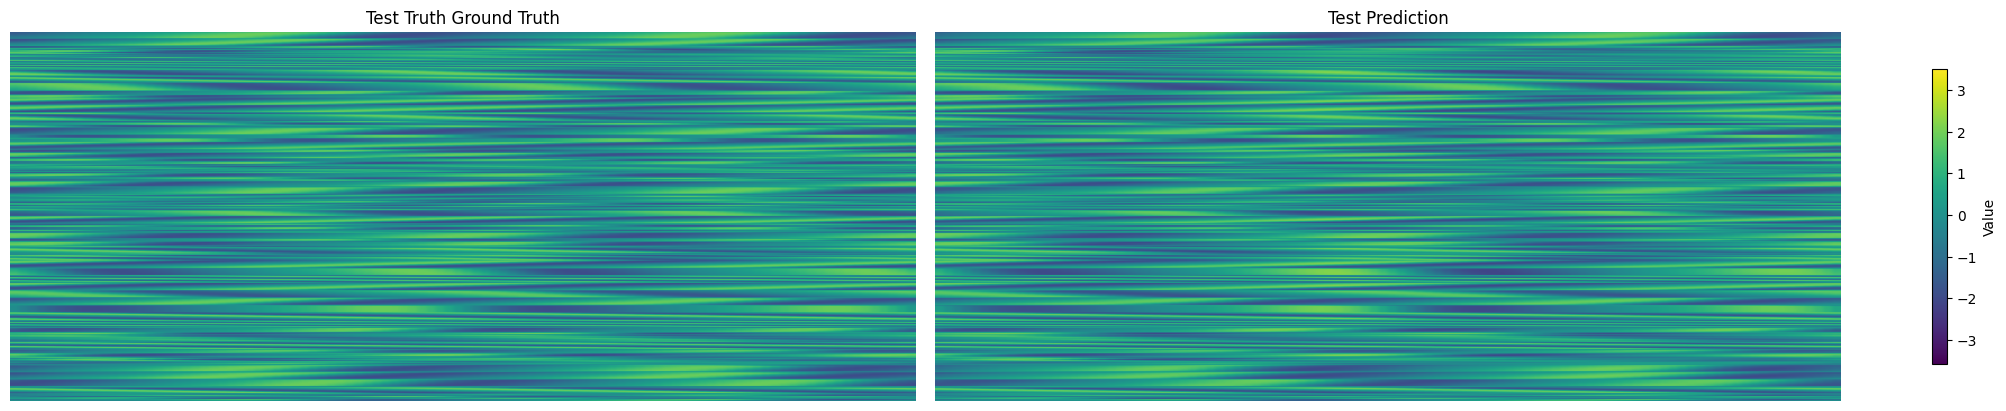

In [53]:
spatial_shape = data.shape[2:]
test_data = data[manager.test_indices]
truth      = test_data.reshape(-1, *spatial_shape)
prediction = test_prediction['KS']

compare_data = [truth, prediction]
titles = ["Test Truth Ground Truth", "Test Prediction"]

vmin, vmax = np.min([d.min() for d in compare_data]), np.max([d.max() for d in compare_data])

fig, axes = plt.subplots(1, 2, figsize=(20, 4), constrained_layout=True)

for ax, d, title in zip(axes, compare_data, titles):
    im = ax.imshow(d, vmin=vmin, vmax=vmax, aspect='auto')
    ax.set(title=title)
    ax.axis("off")

fig.colorbar(im, ax=axes, label="Value", shrink=0.8)

#### Predicted params

In [55]:
params_prediction = test_prediction['MU']
print(params_prediction.shape)
params_prediction

(10050, 2)


array([[1.502923 , 2.701217 ],
       [1.5866294, 4.104658 ],
       [1.6049353, 4.049966 ],
       ...,
       [1.0774401, 2.5793262],
       [0.9692009, 2.925611 ],
       [1.0723687, 2.6876066]], dtype=float32)

#### Evaluate MSE on Ground Truth Data

Since both number of trajectories (`data.shape[0]`) and number of timesteps (`data.shape[1]`) are both variable, we will leave them combined on the first axis. The remaining axes are all spatial dimensions.

In [54]:
# Train
t_train = len(manager.train_sensor_measurements)
train_Y = {'KS': data[0:t_train].reshape(-1, *spatial_shape)} # unpack the spatial dimensions
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# Val
t_val = len(manager.test_sensor_measurements)
val_Y = {'KS': data[t_train:t_train+t_val].reshape(-1, *spatial_shape)}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# Test
t_test = len(manager.test_sensor_measurements)
test_Y = {'KS': data[-t_test:].reshape(-1, *spatial_shape)}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

print('---------- TRAIN ----------')
print(train_error)
print('\n---------- VAL   ----------')
print(val_error)
print('\n---------- TEST  ----------')
print(test_error)

---------- TRAIN ----------
              MSE      RMSE       MAE        R2
dataset                                        
KS       0.085787  0.292894  0.189655  0.934717

---------- VAL   ----------
            MSE      RMSE       MAE        R2
dataset                                      
KS       0.1452  0.381051  0.237308  0.887799

---------- TEST  ----------
             MSE     RMSE       MAE        R2
dataset                                      
KS       0.08774  0.29621  0.185969  0.933305
